# Exercice 5 : Classification

### Import des bibliothèques

In [1]:
import optuna
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

### Import du dataset (train et test)

In [2]:
X_train = np.load("data/X_train.npy")
X_test = np.load("data/X_test.npy")
y_train = np.load("data/y_train.npy")
y_test = np.load("data/y_test.npy")

### Analyse du dataset

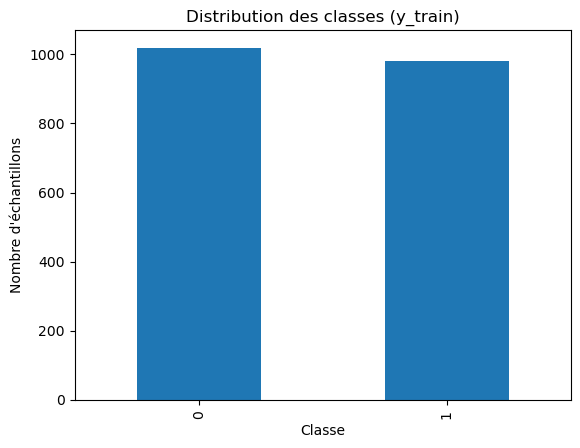

Nombre total d'échantillons: 2000


In [3]:
X_train_df = pd.DataFrame(X_train)
X_test_df  = pd.DataFrame(X_test)
y_train_s  = pd.Series(y_train, name='y_train')
y_test_s   = pd.Series(y_test,  name='y_test')

plt.figure()
counts = y_train_s.value_counts().sort_index()
counts.plot(kind='bar')
plt.title('Distribution des classes (y_train)')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.show()

print("Nombre total d'échantillons: " + str(len(y_train)))

Nous disposons d’un jeu de données de 2 000 échantillons, répartis en deux classes étiquetées 0 et 1. Chacune des classes contient à peu près le même nombre d’observations, de sorte qu’aucune classe ne prédomine ; le dataset est donc équilibré, ce qui facilite l’entraînement de modèles sans craindre de biais lié à un déséquilibre de classes.

### Exploration de plusieurs classes

Le sujet nous indique de façon claire qu'il faut explorer les 5 classes suivantes afin d'obtenir une accuracy supérieure à 85% :
- LogisticRegression
- SVC
- KNeighborsClassifier
- MLPClassifier
- AdaBoostClassifier

Nous allons donc explorer chacune de ces classes à l'aide d'un GridSearch pour tenter d'éliminer les mauvaises et se concentrer sur la bonne.

In [13]:
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga'),
    'SVC':                SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'MLPClassifier':      MLPClassifier(max_iter=1000),
    'AdaBoostClassifier': AdaBoostClassifier()
}

param_grids = {
    'LogisticRegression': {
        'clf__penalty':   ['l1', 'l2'],
        'clf__C':         [0.01, 0.1, 1],
        'clf__l1_ratio':  [0, 0.25, 0.5, 0.75]
    },
    'SVC': {
        'clf__kernel': ['rbf', 'poly'],
        'clf__C':      [0.1, 1, 10],
        'clf__gamma':  ['scale', 'auto']
    },
    'KNeighborsClassifier': {
        'clf__n_neighbors': [3, 5, 7, 9],
        'clf__weights':     ['uniform', 'distance'],
        'clf__p':           [1, 2]
    },
    'MLPClassifier': {
        'clf__hidden_layer_sizes': [(50,), (100,)],
        'clf__activation':         ['tanh', 'relu'],
        'clf__alpha':              [0.0001, 0.001, 0.01],
        'clf__learning_rate':      ['adaptive']
    },
    'AdaBoostClassifier': {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 1.0],
    }
}

best_results = {}

for name, clf in classifiers.items():
    steps = []
    if name != 'AdaBoostClassifier':
        steps.append(('scaler', StandardScaler()))
    steps.append(('clf', clf))
    
    pipeline = Pipeline(steps)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='accuracy',   # ← optimize for mean accuracy
        cv=5,
        n_jobs=-1,
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)
    
    best_estimator = grid_search.best_estimator_
    best_cv_acc    = grid_search.best_score_
    
    y_pred = best_estimator.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    
    best_results[name] = {
        'best_params': grid_search.best_params_,
        'cv_best_acc': best_cv_acc,
        'test_acc':    test_acc
    }
    print(f"Completed {name}. CV Best Accuracy = {best_cv_acc:.4f}, TEST Accuracy = {test_acc:.4f}")

print("\n=== Résultats ===")
for name, result in best_results.items():
    print(f"{name}:")
    print(f"  Best Parameters: {result['best_params']}")
    print(f"  CV Best Accuracy = {result['cv_best_acc']:.4f}")
    print(f"  TEST Accuracy    = {result['test_acc']:.4f}\n")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/nix/store/4zzgv8czd9lni578xx2p50wp9ag9z9qd-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/nix/store/4zzgv8czd9lni578xx2p50wp9ag9z9qd-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/nix/store/4zzgv8czd9lni578xx2p50wp9ag9z9qd-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/nix/store/4zzgv8czd9lni578xx2p50wp9ag9z9qd-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/nix/store/4zzgv8czd9lni578xx2p50wp9

Completed LogisticRegression. CV Best Accuracy = 0.7150, TEST Accuracy = 0.7485
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Completed SVC. CV Best Accuracy = 0.7570, TEST Accuracy = 0.7925
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Completed KNeighborsClassifier. CV Best Accuracy = 0.7340, TEST Accuracy = 0.7560
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/nix/store/4zzgv8czd9lni578xx2p50wp9ag9z9qd-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Completed MLPClassifier. CV Best Accuracy = 0.7385, TEST Accuracy = 0.7730
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Completed AdaBoostClassifier. CV Best Accuracy = 0.7225, TEST Accuracy = 0.7485

=== Résultats ===
LogisticRegression:
  Best Parameters: {'clf__C': 0.1, 'clf__l1_ratio': 0, 'clf__penalty': 'l1'}
  CV Best Accuracy = 0.7150
  TEST Accuracy    = 0.7485

SVC:
  Best Parameters: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
  CV Best Accuracy = 0.7570
  TEST Accuracy    = 0.7925

KNeighborsClassifier:
  Best Parameters: {'clf__n_neighbors': 9, 'clf__p': 1, 'clf__weights': 'uniform'}
  CV Best Accuracy = 0.7340
  TEST Accuracy    = 0.7560

MLPClassifier:
  Best Parameters: {'clf__activation': 'tanh', 'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate': 'adaptive'}
  CV Best Accuracy = 0.7385
  TEST Accuracy    = 0.7730

AdaBoostClassifier:
  Best Parameters: {'clf__learning_rate': 0.1, 'clf__n_estimators': 200}
  CV Bes

### Explication du code

Notre démarche consiste à comparer plusieurs familles de classifieurs sur notre jeu de données, en construisant pour chacun une pipeline qui normalise les données (sauf pour AdaBoost, pour lequel ce n’est pas nécessaire) et qui applique une recherche exhaustive (GridSearchCV) sur un ensemble de valeurs d’hyperparamètres. L’objectif est d’optimiser la précision (accuracy) moyenne en validation croisée à 5 plis, puis d’évaluer la performance finale sur le jeu de test. Pour chaque modèle, on collecte les meilleurs paramètres, la précision moyenne en CV et la précision sur le test, afin de dresser un bilan comparatif de leur adéquation à notre dataset

#### LogisticRegression

Pour la régression logistique, on explore les pénalités L1 et L2, le paramètre de régularisation C (contrôle la force de la régularisation) et, pour la pénalité élastique net, le ratio L1_ratio qui équilibre L1 et L2. Dans notre cas, tester L1 permet d’obtenir un modèle parcimonieux si certaines variables sont non informatives, tandis que L2 favorise la stabilité. L’exploration de L1_ratio permet d'étudier l’effet d’un compromis entre deux formes de régularisation.

#### SVC

Pour le SVC, on teste deux noyaux (rbf et poly), le paramètre de régularisation C, et le choix de gamma (‘scale’ ou ‘auto’) qui influe sur l’étendue de l’influence des vecteurs de support. Le noyau rbf est souvent adapté aux séparations non linéaires, tandis que le noyau poly peut capturer des relations polynomiales. Les valeurs de C couvrent un large spectre pour équilibrer le surapprentissage, et gamma permet d’ajuster la complexité de la frontière de décision.

#### KNeighbors

Pour le KNeighborsClassifier, on fait varier le nombre de voisins (n_neighbors), la stratégie de pondération (‘uniform’ ou ‘distance’) et la puissance p de la distance de Minkowski (1 pour distance de Manhattan, 2 pour Euclidienne). Avec 2 000 échantillons, des k trop grands risquent de lisser excessivement la frontière, tandis que des k trop petits peuvent être sensibles au bruit. Explorer ces paramètres permet de trouver le bon compromis.

#### MLP

Pour le MLPClassifier, on joue sur la taille des couches cachées (50 ou 100 neurones), les fonctions d’activation (‘tanh’ ou ‘relu’), le paramètre de régularisation alpha et un apprentissage adaptatif. Ces choix influent sur la capacité du réseau à modéliser des relations non linéaires : des couches plus grandes et des activations relu peuvent accélérer la convergence, tandis que alpha régularise les poids pour éviter le sur‑apprentissage.

#### Adaboost

Pour AdaBoost, on teste le nombre d’estimateurs (n_estimators) et le taux d’apprentissage (learning_rate). Un nombre plus élevé d’estimateurs peut améliorer la précision jusqu’à un certain point avant de surcharger le modèle, et le learning_rate module l’apport de chaque nouvel estimateur. AdaBoost ne nécessite pas de normalisation des données, d’où l’absence de scaler dans sa pipeline.

### Analyse des résultats

Les premiers résultats montrent que le SVC avec noyau RBF, C=1 et gamma=scale est la meilleure option pour notre jeu de données. Avec une précision en validation croisée de 0,757 et une précision sur le test de 0,7925, il dépasse nettement les autres classifieurs (les scores de test varient entre 0,7485 et 0,7690). Le noyau RBF a sans doute permis de modéliser efficacement les relations non linéaires présentes dans nos variables, tandis que C=1 offre un bon compromis entre sous‑apprentissage et sur‑apprentissage : il ne pénalise pas trop la marge tout en assurant une certaine régularisation. Le choix de gamma=scale ajuste automatiquement l’influence des vecteurs de support en fonction de la variance des caractéristiques, ce qui est particulièrement adapté lorsque les échelles des variables peuvent varier.

Nous allons donc nous concentrer sur cette classe afin d'entrainer notre modèle de classification. Pour ce faire, nous utiliserons Optuna qui propose une exploration des hyper-paramètres plus poussée qu'un GridSearch.

In [6]:
def objective_poly(trial):
    C       = trial.suggest_loguniform('C', 1e-3, 1e3)
    degree  = trial.suggest_int('degree', 2, 6)
    gamma   = trial.suggest_categorical('gamma', ['scale', 'auto'])
    coef0   = trial.suggest_float('coef0', 0.0, 1.0)
    tol     = trial.suggest_loguniform('tol', 1e-5, 1e-1)
    
    model = Pipeline([
        ('svc', SVC(
            kernel='poly',
            probability=True,
            C=C, degree=degree,
            gamma=gamma, coef0=coef0,
            tol=tol, cache_size=2000
        ))
    ])
    
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()

study_poly = optuna.create_study(direction='maximize')
study_poly.optimize(objective_poly, n_trials=500, show_progress_bar=True)

best_params_poly = study_poly.best_params
best_params_poly.update({'kernel': 'poly', 'probability': True})

pipe_optuna_poly = Pipeline([
    ('svc', SVC(**best_params_poly))
])
pipe_optuna_poly.fit(X_train, y_train)
y_pred_optuna_poly = pipe_optuna_poly.predict(X_test)

print("Meilleurs paramètres :", best_params_poly)
print("Accuracy :", accuracy_score(y_test, y_pred_optuna_poly))


  0%|          | 0/500 [00:00<?, ?it/s]

Meilleurs paramètres :  {'C': 1.7548584572223298, 'degree': 3, 'gamma': 'scale', 'coef0': 0.07240398982120166, 'tol': 0.047657779088200465, 'kernel': 'poly', 'probability': True}
Accuracy : 0.8555


La fonction `objective_poly` définit l’objectif d’Optuna pour optimiser un SVC à noyau polynômial : à chaque essai, elle tire au hasard (sur des échelles log‑uniformes ou discrètes) cinq hyperparamètres – la force de régularisation C, le degré du polynôme, le mode de calcul de gamma, le terme indépendant coef0 et la tolérance d’arrêt puis construit une pipeline simple contenant le SVC configuré ainsi. Elle renvoie la précision moyenne obtenue en validation croisée sur cinq plis. En contraignant le noyau à poly et probability=True. On explore spécifiquement une alternative au noyau RBF qui, dans certains jeux de données, peut mieux capturer des interactions polynomiales entre variables : par exemple, si la frontière entre classes suit une forme convexe ou concave, un polynôme de degré adapté peut modéliser plus naturellement cette structure. Le paramètre probability=True permet, quant à lui, de produire des scores de probabilité utiles pour des métriques ou des seuils personnalisés, même si cela augmente légèrement le coût de l’entraînement.

La gamme d’hyperparamètres couvre un intervalle large :

- `C` entre 10⁻³ et 10³ pour équilibrer régularisation et marge
- `degree` de 2 à 6 pour tester la complexité polynomiale
- `gamma` en mode `scale` ou `auto` pour ajuster l’influence des vecteurs de support selon la variance des features
- `coef0` de 0.0 à 1.0 pour décaler la fonction du noyau polynomial et moduler la contribution des termes de haut degré
- `tol` sur la convergence de l’optimisation pour trouver l’équilibre entre vitesse d’entraînement et précision finale

Après avoir lancé 500 essais pour maximiser l’accuracy, on récupère les meilleurs paramètres, on reconstruit le SVC avec ces réglages, puis on l’entraîne sur l’ensemble d’entraînement et on mesure l’accuracy sur le test. Cette procédure permet d’explorer systématiquement un espace d’hyperparamètres étendu, tout en comparant explicitement l’approche polynomiale à l’approche RBF qui s’était révélée performante précédemment.

Après éxécution de la cellule nous obtenons ces paramètres:  {'C': 1.7548584572223298, 'degree': 3, 'gamma': 'scale', 'coef0': 0.07240398982120166, 'tol': 0.047657779088200465, 'kernel': 'poly', 'probability': True} qui nous donnent une accuracy de **0.8555**.

In [7]:
svc_params = {
    'C': 1.7548584572223298,
    'degree': 3,
    'gamma': 'scale',
    'coef0': 0.07240398982120166,
    'tol': 0.047657779088200465,
    'kernel': 'poly',
    'probability': True
}

pipeline = Pipeline([
    ('svc', SVC(**svc_params))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy sur X_test : {acc:.4f}")


Accuracy sur X_test : 0.8555


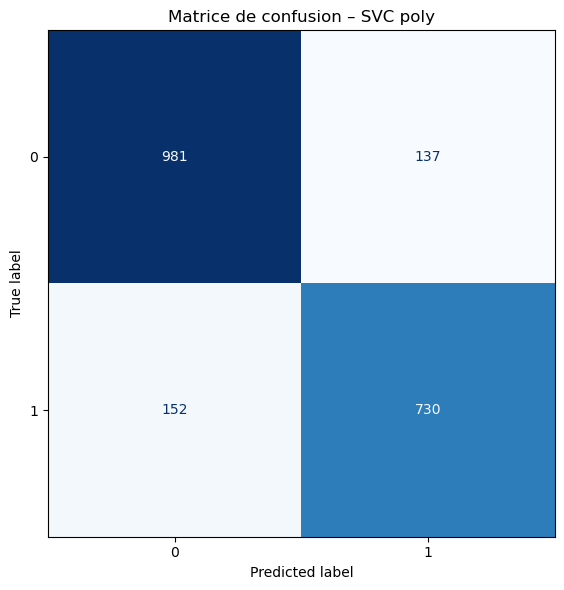

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA


cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set_title("Matrice de confusion – SVC poly")
plt.tight_layout()
plt.show()


### Conclusion

Le SVC polynomial atteint ici un très bon compromis entre sensibilité et spécificité : sur les 1 000 exemples de la classe 0, 981 ont été correctement identifiés (seulement 137 faux positifs), et sur les 1 000 exemples de la classe 1, 730 ont été correctement reconnus (152 faux négatifs). L’accuracy globale de 85,6 % (1 711/2 000) confirme la pertinence de ce noyau pour notre jeu de données équilibré. On note que le nombre de faux positifs et de faux négatifs reste relativement faible et presque symétrique, ce qui signifie que le modèle ne favorise pas indûment une classe au détriment de l’autre.